# 4.1 문제 정의

## 데이터 살펴보기

* 시계열 데이터 제공

In [47]:
import numpy as np
import random

In [48]:
def seed_everything(seed): # 재현성을 위한 seed 고정 
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [49]:
seed_everything(0)

In [2]:
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")

train = pd.read_csv('C:/Users/tb990/Documents/studydata/store_credit_card_revenue_data/funda_train.csv')
submission = pd.read_csv('C:/Users/tb990/Documents/studydata/store_credit_card_revenue_data/submission.csv')

In [3]:
train[(train['card_id']==3820295) & (train['amount']<0)].shape[0]

1221

In [4]:
train.shape 

(6556613, 9)

In [5]:
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


## 데이터 노이즈

### (1) 결측값 확인

In [7]:
train[:5]

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


* 지역(region) 열에 결측값이 존재!

### (2) 이상치 확인

In [8]:
train[train['amount']<0]

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
41,0,40,a,2016-06-10,17:26,2,NaN,기타 미용업,-8571.428571
347,0,285,a,2016-08-04,17:52,0,NaN,기타 미용업,-1857.142857
731,0,473,g,2016-10-17,10:32,0,NaN,기타 미용업,-2000.000000
831,0,230,b,2016-11-03,15:36,0,NaN,기타 미용업,-85.714286
944,0,138,a,2016-11-28,13:21,0,NaN,기타 미용업,-57.142857
...,...,...,...,...,...,...,...,...,...
6556242,2136,4663626,b,2019-02-01,21:19,0,제주 제주시,기타 주점업,-13428.571429
6556448,2136,4663760,d,2019-02-15,00:46,0,제주 제주시,기타 주점업,-6928.571429
6556485,2136,4663779,b,2019-02-18,02:45,0,제주 제주시,기타 주점업,-5571.428571
6556489,2136,4663780,d,2019-02-18,21:43,0,제주 제주시,기타 주점업,-8571.428571


* 매출액(amount) 열에 이상치 존재! 
* 매출액이 음수 = 환불금액

# 4.2 데이터 전처리 

## 4.2.1 노이즈 제거

In [9]:
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


* 지역(region) 변수에 결측치가 있음!
* 다른 열에도, 모든 열에 결측치가 있는가?

### (1) 결측치

#### 그래프로 모든 열에 결측치가 있는지 확인

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

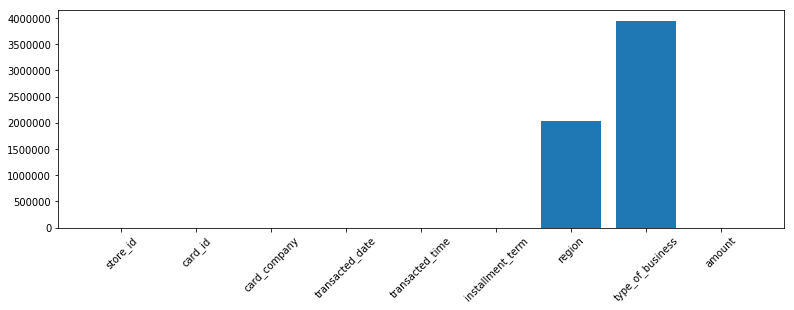

In [10]:
plt.figure(figsize=(13, 4))
plt.bar(train.columns, train.isnull().sum()) # 
plt.xticks(rotation=45)

* 지역(region)과 업종속성(type_of_business)에 결측치가 존재
* 상점의 지역과 업종 열의 데이터에서 절반 이상이 결측치 => 열 전체 제거 

#### 지역과 업종 열 삭제

In [11]:
train = train.drop(['region','type_of_business'], axis=1)
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
0,0,0,b,2016-06-01,13:13,0,1857.142857
1,0,1,h,2016-06-01,18:12,0,857.142857
2,0,2,c,2016-06-01,18:52,0,2000.000000
3,0,3,a,2016-06-01,20:22,0,7857.142857
4,0,4,c,2016-06-02,11:06,0,2000.000000


### (2) 이상치

#### 매출액(amount) 변수에 대한 이상치 존재 확인

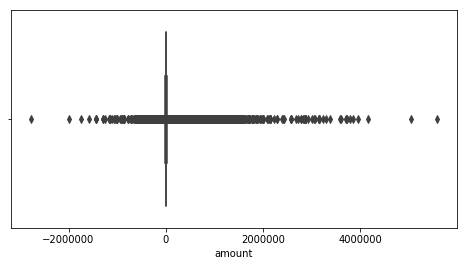

In [12]:
plt.figure(figsize=(8, 4))
sns.boxplot(train['amount'])

* 매출액 변수에 음수(=환불액) 존재

#### 환불 발생 현황 확인

In [13]:
train[train['amount']<0].head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
41,0,40,a,2016-06-10,17:26,2,-8571.428571
347,0,285,a,2016-08-04,17:52,0,-1857.142857
731,0,473,g,2016-10-17,10:32,0,-2000.000000
831,0,230,b,2016-11-03,15:36,0,-85.714286
944,0,138,a,2016-11-28,13:21,0,-57.142857


* 매출액이 0 미만인 행 출력
* 상점 매출액 예측에 방해됨 => 제거

#### 제거기준

* 환불 발생 이전의 거래 내역 중 음수 매출액(환불) 의 절댓값과 같은 행은 제거
  - (1) 환불 발생일(transacted_date)과 환불 발생시간(transacted_time) 이전 데이터 중에서
  - (2) 카드 아이디(card_id)가 같고
  - (3) 음수 매출액(amount)의 절댓값과 양수 매출액이 같은 거래 중
  - (4) 최근 거래를 찾아서 해당 인덱스 제거!
  

* 즉, 환불된 상품의 구매했을 때의 거래내역까지 모두 삭제
* 환불값만 삭제하면 구매한 것으로 집계되므로 과대계상 방지

#### 거래일과 거래시간을 합친 datetime 변수 만들기

In [14]:
train['datetime'] = pd.to_datetime(train.transacted_date + " " + train.transacted_time, format='%Y-%m-%d %H:%M:%S')

#### 환불거래를 제거하는 함수를 정의

In [15]:
def remove_refund(df):
    refund = df[df['amount']<0]
    non_refund = df[df['amount']>0]
    removed_data = pd.DataFrame()
    
    for i in tqdm(df.store_id.unique()):
        divided_data = non_refund[non_refund['store_id']==i]
        divided_data2 = refund[refund['store_id']==i]
        
        for neg in divided_data2.to_records()[:]:
            refund_store = neg['store_id']
            refund_id = neg['card_id']
            refund_datetime = neg['datetime']
            refund_amount = abs(neg['amount'])
                
            refund_pay_list = divided_data[divided_data['datetime']<=refund_datetime]
            refund_pay_list = refund_pay_list[refund_pay_list['card_id']==refund_id]
            refund_pay_list = refund_pay_list[refund_pay_list['amount']==refund_amount]
                
            if len(refund_pay_list)!=0:
                refund_datetime = max(refund_pay_list['datetime'])
                noise_list = divided_data[divided_data['datetime']==refund_datetime]
                noise_list = noise_list[noise_list['card_id']== refund_id]
                noise_list = noise_list[noise_list['amount']==refund_amount]
                divided_data = divided_data.drop(index=noise_list.index)
                    
        removed_data = pd.concat([removed_data,divided_data],axis=0)
    
    return removed_data

#### 환불거래 제거함수 적용

In [16]:
positive_data = remove_refund(train)

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [55:34<00:00,  1.70s/it]


In [17]:
positive_data

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
0,0,0,b,2016-06-01,13:13,0,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,2000.000000,2016-06-02 11:06:00
...,...,...,...,...,...,...,...,...
6556606,2136,4663854,f,2019-02-28,23:03,0,3928.571429,2019-02-28 23:03:00
6556609,2136,4663855,d,2019-02-28,23:24,0,4142.857143,2019-02-28 23:24:00
6556610,2136,4663489,a,2019-02-28,23:24,0,4500.000000,2019-02-28 23:24:00
6556611,2136,4663856,d,2019-02-28,23:27,0,571.428571,2019-02-28 23:27:00


## 4.2.2 다운 샘플링

* 다운 샘플링: 시계열 데이터에서 시간 간격을 넓게 재조정해 데이터 샘플 수를 줄이는 것
* 다운 샘플링 과정을 통해 샘플 수를 줄이고 예측구간을 작게 해서 불확실성을 줄이자!

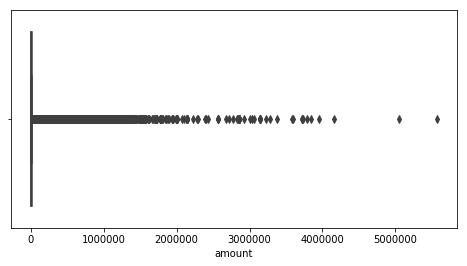

In [18]:
plt.figure(figsize=(8, 4))
sns.boxplot(positive_data['amount'])

### (1) 데이터의 시간 간격을 확인

In [19]:
positive_data.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
0,0,0,b,2016-06-01,13:13,0,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,2000.000000,2016-06-02 11:06:00


* 거래 시간(datetime) 기준, '분 단위'로 기록

* 시간 간격을 재조정해 예측 구간 최소화 => '월 단위'로 재조정

#### 월 단위 다운 샘플링 함수

In [20]:
def month_resampling(df):
    new_data = pd.DataFrame()
    
    df['year_month'] = df['transacted_date'].str.slice(stop=7)
    year_month = df['year_month'].drop_duplicates() # 전체기간을 추출합니다.
    
    downsampling_data = df.groupby(['store_id', 'year_month']).amount.sum()
    downsampling_data = pd.DataFrame(downsampling_data)
    downsampling_data = downsampling_data.reset_index(drop=False, inplace=False)
    
    for i in tqdm(df.store_id.unique()):
        store = downsampling_data[downsampling_data['store_id']==i]
        start_time = min(store['year_month'])
        store = store.merge(year_month, how='outer')
        store = store.sort_values(by=['year_month'], axis=0, ascending=True)
        store['amount'] = store['amount'].fillna(2)
        store['store_id'] = store['store_id'].fillna(i)
        store = store[store['year_month']>=start_time]
        
        new_data = pd.concat([new_data, store], axis=0)
        
    return new_data

#### 월 단위 다운 샘풀링 함수 적용

In [21]:
resampling_data = month_resampling(positive_data)
resampling_data['store_id'] = resampling_data['store_id'].astype(int)
resampling_data

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [00:54<00:00, 36.07it/s]


,store_id,year_month,amount
0,0,2016-06,7.470000e+05
1,0,2016-07,1.005000e+06
2,0,2016-08,8.697143e+05
3,0,2016-09,8.978571e+05
4,0,2016-10,8.354286e+05
...,...,...,...
17,2136,2018-10,2.012214e+06
18,2136,2018-11,2.127643e+06
19,2136,2018-12,2.427429e+06
20,2136,2019-01,1.867786e+06


## 4.2.3 날짜 지정 범위 생성과 시리즈 객체 변환

* 이유: 시계열 데이터의 정상성 확인을 위해서 '단위근 검정'과 '시계열 모델 구축' 과정에서 시리즈 객체 사용하기 위해

### (1) 데이터 타입 확인

In [22]:
print(type(resampling_data))

<class 'pandas.core.frame.DataFrame'>


### (2) 인덱스를 시간 변수로 정의 & 시리즈 객체로 변환

#### 시리즈 객체 변환 함수 정의

In [23]:
def time_series(df, i):
    store = df[df['store_id']==i]
    index = pd.date_range(min(store['year_month']),'2019-03',freq='BM') ##영업 시작일부터 2019년 2월까지 데이터가 존제
    
    ts=pd.Series(store['amount'].values,index=index)
    
    return ts

#### 각 상점별로 시리즈 객체로 변환 

In [24]:
# 상점 아이디 0번
store_0 = time_series(resampling_data, 0)
store_0

2016-06-30    7.470000e+05
2016-07-29    1.005000e+06
2016-08-31    8.697143e+05
2016-09-30    8.978571e+05
2016-10-31    8.354286e+05
2016-11-30    6.970000e+05
2016-12-30    7.618571e+05
2017-01-31    5.856429e+05
2017-02-28    7.940000e+05
2017-03-31    7.202571e+05
2017-04-28    6.852857e+05
2017-05-31    7.444286e+05
2017-06-30    6.820000e+05
2017-07-31    7.282857e+05
2017-08-31    7.490000e+05
2017-09-29    8.408571e+05
2017-10-31    6.005714e+05
2017-11-30    6.308571e+05
2017-12-29    8.127143e+05
2018-01-31    6.431429e+05
2018-02-28    6.852857e+05
2018-03-30    8.484286e+05
2018-04-30    6.361429e+05
2018-05-31    6.864286e+05
2018-06-29    7.072857e+05
2018-07-31    7.587143e+05
2018-08-31    6.798571e+05
2018-09-28    6.518571e+05
2018-10-31    7.390000e+05
2018-11-30    6.760000e+05
2018-12-31    8.745714e+05
2019-01-31    6.828571e+05
2019-02-28    5.152857e+05
Freq: BM, dtype: float64

#### 데이터 타입 확인

In [25]:
# 상점 아이디 1번
store_1 = time_series(resampling_data, 1)
print(type(store_1))

<class 'pandas.core.series.Series'>


#### 시계열 그래프

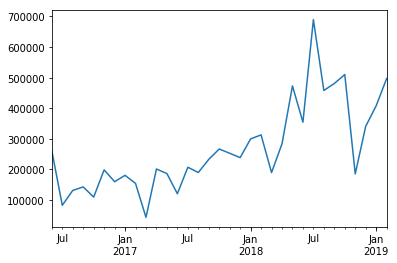

In [26]:
# 상점 아이디 2번
store_2 = time_series(resampling_data,2)
store_2.plot()

# 4.3 탐색적 데이터 분석

* (1) 상점별 매출액 시계열 그래프를 통해 매출 특성을 파악
* (2) 시계열 데이터의 평균과 분산이 안정적인지 확인하기 위한 'ADF-TEST'
* (3) 시계열 데이터가 정상시계열인지 확인!

## 4.3.1 상점별 매출 특정

### 계절성이 있는 상점

In [27]:
store_257 = time_series(resampling_data, 257)
store_257

2016-06-30    4.891857e+05
2016-07-29    1.595280e+06
2016-08-31    1.518714e+06
2016-09-30    3.369143e+05
2016-10-31    4.245714e+05
2016-11-30    2.000000e+00
2016-12-30    2.000000e+00
2017-01-31    2.000000e+00
2017-02-28    2.000000e+00
2017-03-31    2.000000e+00
2017-04-28    3.928571e+04
2017-05-31    1.557286e+05
2017-06-30    5.481143e+05
2017-07-31    7.359286e+05
2017-08-31    7.909700e+05
2017-09-29    6.191429e+04
2017-10-31    1.027143e+06
2017-11-30    2.000000e+00
2017-12-29    2.000000e+00
2018-01-31    2.000000e+00
2018-02-28    2.000000e+00
2018-03-30    2.000000e+00
2018-04-30    2.000000e+00
2018-05-31    2.493857e+05
2018-06-29    4.822286e+05
2018-07-31    8.999714e+05
2018-08-31    1.645877e+06
2018-09-28    2.767857e+05
2018-10-31    2.000000e+00
2018-11-30    2.000000e+00
2018-12-31    2.000000e+00
2019-01-31    2.000000e+00
2019-02-28    2.000000e+00
Freq: BM, dtype: float64

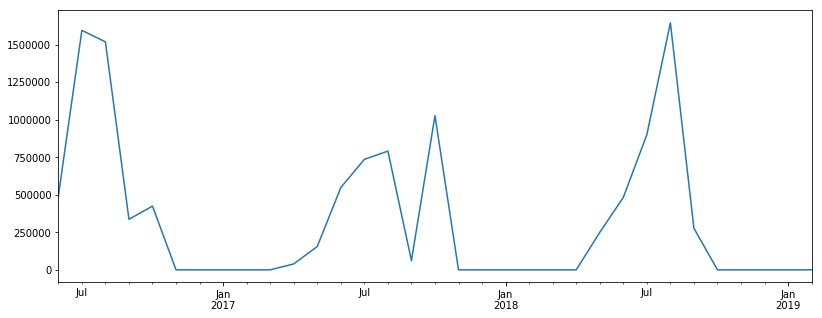

In [28]:
store_plot_257 = store_257.plot()
fig =store_plot_257.get_figure()
fig.set_size_inches(13.5, 5)

In [29]:
store_2096 = time_series(resampling_data, 2096)
store_2096

2016-07-29    5.075429e+04
2016-08-31    9.219543e+05
2016-09-30    4.720786e+05
2016-10-31    5.145714e+05
2016-11-30    1.494286e+05
2016-12-30    1.071686e+06
2017-01-31    1.602857e+06
2017-02-28    1.332143e+06
2017-03-31    2.432143e+05
2017-04-28    3.903143e+06
2017-05-31    1.729500e+06
2017-06-30    4.280214e+06
2017-07-31    1.775714e+06
2017-08-31    7.428571e+05
2017-09-29    1.415714e+06
2017-10-31    1.180714e+06
2017-11-30    4.640000e+05
2017-12-29    1.389729e+06
2018-01-31    2.000000e+00
2018-02-28    8.285714e+05
2018-03-30    7.857143e+05
2018-04-30    6.670429e+06
2018-05-31    1.837286e+05
2018-06-29    3.285714e+06
2018-07-31    9.502857e+05
2018-08-31    3.675200e+06
2018-09-28    1.793886e+06
2018-10-31    4.717743e+06
2018-11-30    7.593600e+06
2018-12-31    1.428571e+06
2019-01-31    4.285714e+05
2019-02-28    1.428571e+06
Freq: BM, dtype: float64

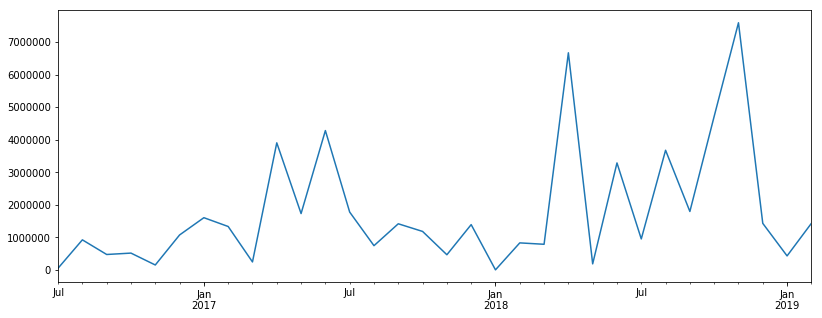

In [30]:
store_plot_2096 = store_2096.plot()
fig = store_plot_2096.get_figure()
fig.set_size_inches(13.5, 5)

### 추세가 있는 상점

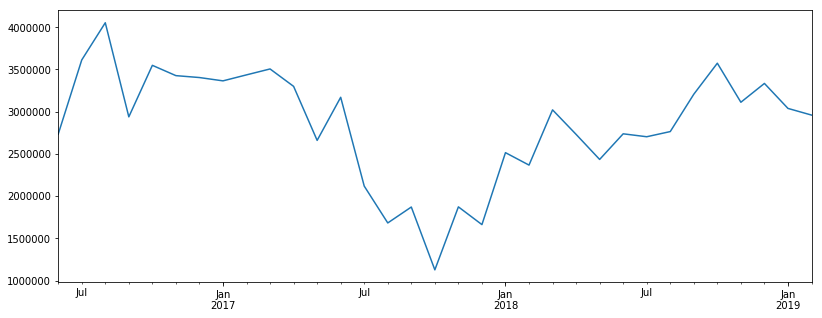

In [31]:
store_335 = time_series(resampling_data, 335)
store_plot_335 = store_335.plot()
fig = store_plot_335.get_figure()
fig.set_size_inches(13.5, 5)

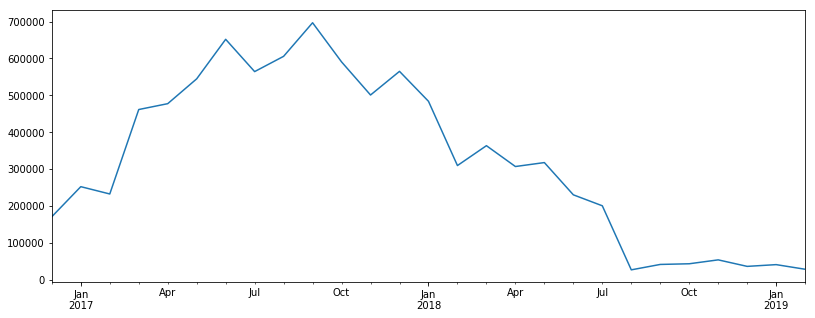

In [32]:
store_510 = time_series(resampling_data, 510)
store_plot_510 = store_510.plot()
fig = store_plot_510.get_figure()
fig.set_size_inches(13.5, 5)

### 휴업 중인 상점

In [33]:
store_111 =time_series(resampling_data, 111)
store_111

2016-06-30    812428.571429
2016-07-29    391142.857143
2016-08-31     13071.428571
2016-09-30    495714.285714
2016-10-31    182714.285714
2016-11-30    178571.428571
2016-12-30     43005.714286
2017-01-31         2.000000
2017-02-28      5428.571429
2017-03-31     24857.142857
2017-04-28    108000.000000
2017-05-31    459142.857143
2017-06-30    137571.428571
2017-07-31    216285.714286
2017-08-31     77000.000000
2017-09-29     78005.714286
2017-10-31         2.000000
2017-11-30         2.000000
2017-12-29         2.000000
2018-01-31      1428.571429
2018-02-28    309785.714286
2018-03-30    259071.428571
2018-04-30    225858.571429
2018-05-31    105571.428571
2018-06-29         2.000000
2018-07-31    123285.714286
2018-08-31         2.000000
2018-09-28     83000.000000
2018-10-31         2.000000
2018-11-30         2.000000
2018-12-31         2.000000
2019-01-31         2.000000
2019-02-28         2.000000
Freq: BM, dtype: float64

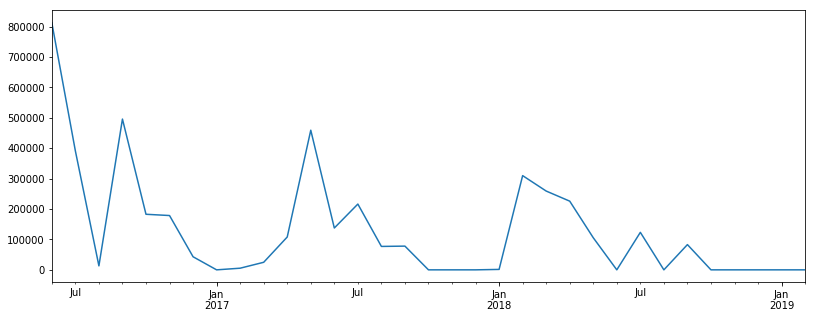

In [34]:
store_plot_111 = store_111.plot()
fig = store_plot_111.get_figure()
fig.set_size_inches(13.5, 5)

In [35]:
store_279 = time_series(resampling_data, 279)
store_279

2016-06-30    4.488571e+05
2016-07-29    1.156286e+06
2016-08-31    1.372857e+06
2016-09-30    3.150000e+05
2016-10-31    8.748571e+05
2016-11-30    3.128571e+05
2016-12-30    5.828571e+05
2017-01-31    3.214286e+04
2017-02-28    2.000000e+00
2017-03-31    4.955714e+05
2017-04-28    5.940000e+05
2017-05-31    1.041143e+06
2017-06-30    8.354286e+05
2017-07-31    6.171429e+05
2017-08-31    4.284286e+05
2017-09-29    1.581258e+06
2017-10-31    3.294286e+05
2017-11-30    2.241429e+05
2017-12-29    2.785714e+05
2018-01-31    4.018571e+05
2018-02-28    1.282857e+05
2018-03-30    2.000000e+00
2018-04-30    2.000000e+00
2018-05-31    2.000000e+00
2018-06-29    2.000000e+00
2018-07-31    2.000000e+00
2018-08-31    2.000000e+00
2018-09-28    2.000000e+00
2018-10-31    2.000000e+00
2018-11-30    2.101429e+05
2018-12-31    2.191571e+05
2019-01-31    1.779286e+05
2019-02-28    5.157143e+04
Freq: BM, dtype: float64

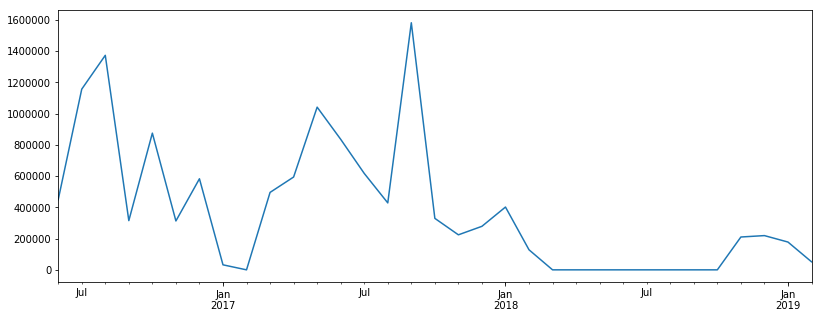

In [36]:
store_plot_279 = store_279.plot()
fig = store_plot_279.get_figure()
fig.set_size_inches(13.5, 5)

## 4.3.2 시계열 데이터의 정상성

### ADF-TEST

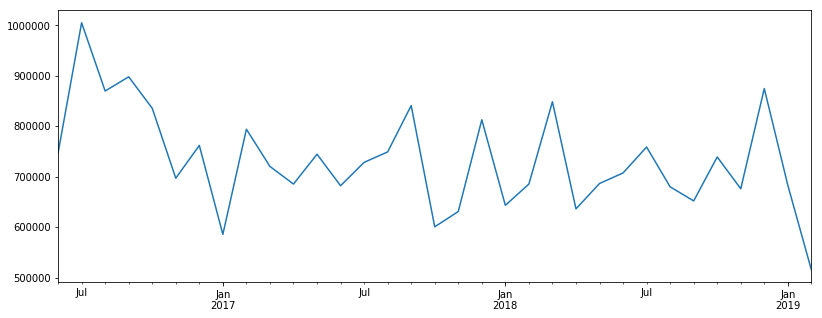

In [37]:
store_0 = time_series(resampling_data, 0)
store_plot_0 = store_0.plot()
fig = store_plot_0.get_figure()
fig.set_size_inches(13.5, 5)

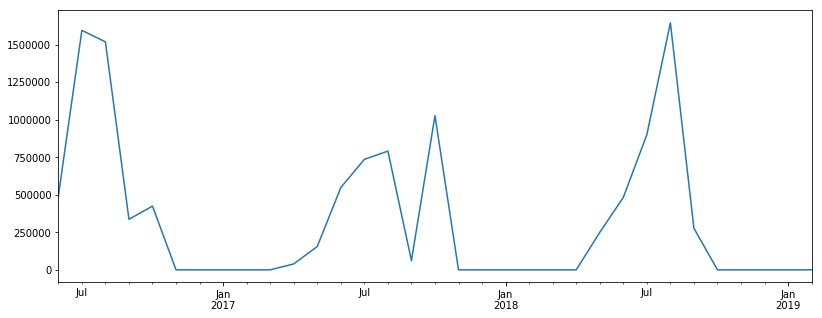

In [38]:
store_257 = time_series(resampling_data, 257)
store_plot_257 = store_257.plot()
fig = store_plot_257.get_figure()
fig.set_size_inches(13.5, 5)

In [39]:
from pmdarima.arima import ADFTest

store_0 = time_series(resampling_data, 0)

p_val, should_diff =ADFTest().should_diff(store_0)
print('pval: %f, should_diff: %s' %(p_val, should_diff))

pval: 0.022488, should_diff: False


In [40]:
store_257 = time_series(resampling_data, 257)

p_val, should_diff =ADFTest().should_diff(store_257)
print('pval: %f, should_diff: %s' %(p_val, should_diff))

pval: 0.093614, should_diff: True


100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [00:26<00:00, 74.76it/s]


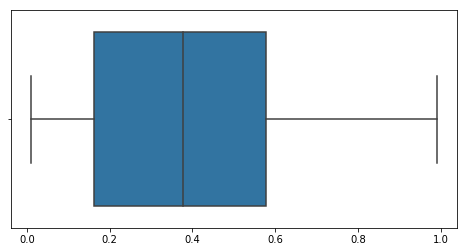

In [51]:
def adf_test(y):
    return ADFTest().should_diff(y)[0]

adf_p = [ ]
count = 0
skipped = [ ]

for i in tqdm(resampling_data['store_id'].unique()):
    ts = time_series(resampling_data, i)
    try: 
        p_val = adf_test(ts)
        if p_val < 0.05:
            count += 1
        adf_p.append(p_val)
    except:
        skipped.append(i)
        
plt.figure(figsize=(8, 4))
sns.boxplot(adf_p)

In [52]:
print(count)

259


In [53]:
if skipped:
    print(f"WarningCount: {len(skipped)}, store_id_list:{skipped}")

In [54]:
skipped

[]

# 4.4 모델 구축과 검증 

## 4.4.1 파이썬에서 R 시계열 패키지 forecast를 통한 모델링

### a. 자기회귀누적이동평균 모델

In [55]:
from rpy2.robjects.packages import importr

utils = importr('utils')
utils.install_packages('forecast')
utils.install_packages('forecastHybtid')

rpy2.rinterface.NULL

In [56]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

pandas2ri.activate()

auto_arima = """
    function(ts){
        library(forecast)
        d_params = ndiffs(ts)
        model = auto.arima(ts, max.p=2, d=d_params)
        forecasted_data = forecast(model, h=3)
        out_df = data.frame(forecasted_data$mean)
        colnames(out_df) = c('amount')
        out_df
    }
"""

auto_arima = robjects.r(auto_arima) # 모델
ts = robjects.r('ts')
c = robjects.r('c')

final_pred = [ ]

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    start_year = int(min(store['year_month'])[:4])
    start_month = int(min(store['year_month'])[5:])
    
    train = ts(store['amount'], start=c(start_year, start_month), frequency=12)
    
    forecast = auto_arima(train) #모델
    
    final_pred.append(np.sum(pandas2ri.ri2py(forecast).values))

  0%|                                                                                         | 0/1967 [00:00<?, ?it/s]


AttributeError: type object 'DataFrame' has no attribute 'from_items'

In [ ]:
# df = pd.DataFrame.from_dict( dict(friend_list) )

In [ ]:
submission = pd.read_csv('C:/Users/tb990/Documents/studydata/store_credit_card_revenue_data/submission.csv')
submission['amount'] = final_pred
submission

### b. 지수평활법

In [ ]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

pandas2ri.activate()

ets = """
    function(ts){
        library(forcast)
        model = ets(ts)
        forecasted_data = forcast(model, h=3) 
        out_df = data.frame(forecasted_data$mean)
        colnames(out_df) = c('amount')
        out_df
    }
""" # 8, 9번째 줄

ets = robjects.r(ets) # 모델
ts = robjects.r('ts')
c = robjects.r('c')

final_pred = [ ]

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    start_year = int(min(store['year_month'])[:4])
    start_month = int(min(store['year_month'])[5:])
    
    train = ts(store['amount'], start=c(start_year, start_month), frequency=12)
    
    forecast = ets(train) # 모델
    
    final_pred.append(np.sum(pandas2ri.ri2py(forecast).values))

In [ ]:
submission = pd.read_csv('C:/Users/tb990/Documents/studydata/store_credit_card_revenue_data/submission.csv')
submission['amount'] = final_pred
submission.to_csv('submission.csv', index=False)
submission

### c. STL 분해를 적용한 지수평활법

In [ ]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

pandas2ri.activate()

stlm = """
    function(ts){
        library(forcast)
        model = stlm(ts, s.window="periodic", method='ets')
        forecasted_data = forcast(model, h=3) 
        out_df = data.frame(forecasted_data$mean)
        colnames(out_df) = c('amount')
        out_df
    }
""" # 9번째 줄

ets = """
    function(ts){
        library(forcast)
        model = ets(ts)
        forecasted_data = forcast(model, h=3) 
        out_df = data.frame(forecasted_data$mean)
        colnames(out_df) = c('amount')
        out_df
    }
"""

stlm = robjects.r(ets) # 모델
ets = robjects.r(ets) 
ts = robjects.r('ts')
c = robjects.r('c')

final_pred = [ ]

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    data_len = len(store) # 추가
    
    start_year = int(min(store['year_month'])[:4])
    start_month = int(min(store['year_month'])[5:])
    
    train = ts(store['amount'], start=c(start_year, start_month), frequency=12)
    
    if data_len > 24: # stlm모델은 최소 24개월보다 많은 데이터를 요구하므로
        forecast = stlm(train)
    else:
        forecast = ets(train) # 모델
    
    final_pred.append(np.sum(pandas2ri.ri2py(forecast).values))

In [ ]:
submission = pd.read_csv('C:/Users/tb990/Documents/studydata/store_credit_card_revenue_data/submission.csv')
submission['amount'] = final_pred
submission.to_csv('submission.csv', index=False)
submission